In [38]:
import numpy as np
import pandas as pd
import yfinance as yf

In [39]:
nifty = yf.Ticker('^NSEI')
nifty_data = nifty.history(period = '1y')

nifty_data.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2026-01-20 00:00:00+05:30,25580.300781,25585.000000,25171.349609,25232.500000,409800,0.0,0.0
2026-01-21 00:00:00+05:30,25141.000000,25300.949219,24919.800781,25157.500000,395600,0.0,0.0
2026-01-22 00:00:00+05:30,25344.150391,25435.750000,25168.500000,25289.900391,486400,0.0,0.0
2026-01-23 00:00:00+05:30,25344.599609,25347.949219,25025.300781,25048.650391,393900,0.0,0.0
2026-01-27 00:00:00+05:30,25063.349609,25246.650391,24932.550781,25175.400391,0,0.0,0.0


In [40]:
print(nifty_data.shape)

(248, 7)


In [42]:
df = nifty_data
# dates = df.index

# cur_dated = []
# for d in dates:
#     cur_dated.append(str(d)[:10])

# cur_dated = pd.Series(cur_dated)
# df.index = cur_dated
# df.head()

df.index = df.index.strftime('%Y-%m-%d')

In [43]:
# df['2025-04-01': '2025-05-01'].to_csv('excel.csv')

<Axes: xlabel='Date'>

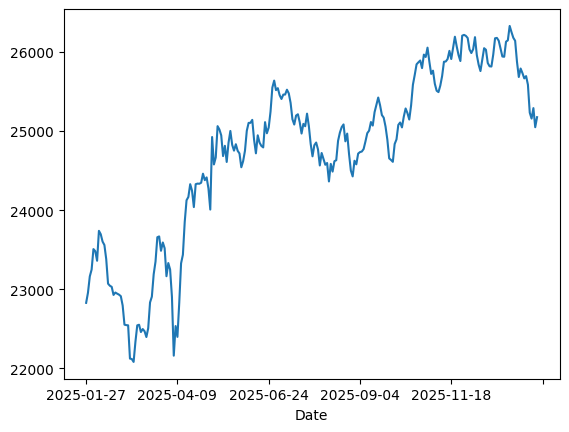

In [65]:
nifty_data['Close'].plot(kind = 'line')

<Axes: xlabel='Date'>

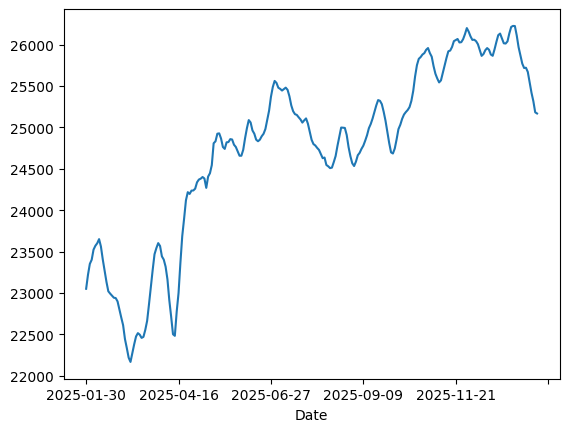

In [64]:
df['Close'].rolling(window = 4).mean().dropna().plot()

In [ ]:
df.rolling